# Multi-modality (WHISPER)

In this workshop you will recreate (partial) results from the paper ["Deep speech-to-text models capture the neural basis of spontaneous speech in
everyday conversations](https://www.biorxiv.org/content/10.1101/2023.06.26.546557v1.full.pdf)".

You will need to:
1. Use WhisperX to align audio and transcript in time
2. Extract speech and language embeddings from Whisper model
5. Train a classifier on the embeddings for the phonetic and lexical categories.

As audio you will be using the first 30 min of the podcast "[So a Monkey and a Horse Walk Into a Bar](https://www.thisamericanlife.org/631/so-a-monkey-and-a-horse-walk-into-a-bar)" (the transcript for which is availible so you can evaluate the model's performance on it if you want).

Install **whisperx** from [github repo](https://github.com/m-bain/whisperX).

You will use it to get the time-stamps for each word, which then will serve as inputs to the original Whisper model.

In [1]:
!pip install git+https://github.com/m-bain/whisperx.git
!pip install -U openai-whisper

  Cloning https://github.com/m-bain/whisperx.git to /tmp/pip-req-build-9v1cg3ir
  Running command git clone --filter=blob:none --quiet https://github.com/m-bain/whisperx.git /tmp/pip-req-build-9v1cg3ir
  Resolved https://github.com/m-bain/whisperx.git to commit e906be9688334b4ae7d3a23f69734ac901a255ee
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/SYSTRAN/faster-whisper.git (to revision 0.10.0) to /tmp/pip-install-otkjz63s/faster-whisper_10e188e1e8e6494d83cd143ae716c184
  Running command git clone --filter=blob:none --quiet https://github.com/SYSTRAN/faster-whisper.git /tmp/pip-install-otkjz63s/faster-whisper_10e188e1e8e6494d83cd143ae716c184
  Running command git checkout -q e1a218fab1ab02d637b79565995bf1a9c4c83a09
  Resolved https://github.com/SYSTRAN/faster-whisper.git to commit e1a218fab1ab02d637b79565995bf1a9c4c83a09
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.7/208.7 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.6/798.6 kB 16.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 90.1 MB/s eta 0:00:00
  Created wheel for openai-whisper: filename=openai_whisper-20231117-py3-none-any.whl size=801356 sha256=bf37900f427c27a634dcf854b176272f20713f7f2e5191928d64c562c0be1ea7
  Stored in directory: /root/.cache/pip/wheels/d0/85/e1/9361b4cbea7dd4b7f6702fa4c3afc94877952eeb2b62f45f56
Successfully built openai-whisper
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires openai, which is not installed.


Load the WhisperX model and the audio of the podcast, transcribe it into text using the model and then align it.

Take a look at the exmaple in the README of the WhisperX [repo](https://github.com/m-bain/whisperX?tab=readme-ov-file#python-usage--) to see how it's done (copy only parts 1 and 2, there is no need to assign speakers).

In [2]:
import whisperx
import gc
import torch

device = "cuda"
audio_file = "MITM_podcast_30min.mp3"
batch_size = 16 # reduce if low on GPU mem
compute_type = "float16" # change to "int8" if low on GPU mem (may reduce accuracy)

# 1. Transcribe with original whisper (batched)
model = whisperx.load_model("large-v2", device, compute_type=compute_type)

audio = whisperx.load_audio(audio_file)
result = model.transcribe(audio, batch_size=batch_size)

# delete model if low on GPU resources
gc.collect(); torch.cuda.empty_cache(); del model

# 2. Align whisper output
model_a, metadata = whisperx.load_align_model(language_code=result["language"], device=device)
result = whisperx.align(result["segments"], model_a, metadata, audio, device, return_char_alignments=False)

gc.collect(); torch.cuda.empty_cache(); del model_a


/usr/local/lib/python3.10/dist-packages/pyannote/audio/core/io.py:43: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("soundfile")


vocabulary.txt:   0%|          | 0.00/460k [00:00<?, ?B/s]

model.bin:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.20M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.80k [00:00<?, ?B/s]

No language specified, language will be first be detected for each audio file (increases inference time).


100%|█████████████████████████████████████| 16.9M/16.9M [00:02<00:00, 7.88MiB/s]
INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.2.0.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../root/.cache/torch/whisperx-vad-segmentation.bin`


Model was trained with pyannote.audio 0.0.1, yours is 3.1.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.1.0+cu121. Bad things might happen unless you revert torch to 1.x.
Detected language: en (1.00) in first 30s of audio...


Downloading: "https://download.pytorch.org/torchaudio/models/wav2vec2_fairseq_base_ls960_asr_ls960.pth" to /root/.cache/torch/hub/checkpoints/wav2vec2_fairseq_base_ls960_asr_ls960.pth
100%|██████████| 360M/360M [00:01<00:00, 287MB/s]


Now load pre-trained Whisper Tiny model, tokenizer and processor from HuggingFace with the name `openai/whisper-tiny` using the classes  AutoModelForSpeechSeq2Seq, AutoTokenizer, and AutoProcessor accordingly.

For technical reasons, after loading the model run the following line of code (assuming your variable is named 'model'):

`model.config.forced_decoder_ids = None`

In [3]:
from transformers import AutoProcessor, AutoModelForSpeechSeq2Seq, AutoTokenizer
import whisper

model_name = "openai/whisper-tiny"

model = AutoModelForSpeechSeq2Seq.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space=True)
processor = AutoProcessor.from_pretrained(model_name)

tokens_vocab = tokenizer.get_vocab()
model.config.forced_decoder_ids = None

config.json:   0%|          | 0.00/1.98k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/151M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.75k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/805 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.08k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

Using the output of WhisperX create a pandas [DateFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) which contains three columns: ["token", "audio_onset", "audio_offset"] with the corresponding values for each token in the transcript.

Tip: print out the value of `result["segments"][0]` to understand the structure.

**Note**: make sure to only use words for which WhisperX returned a timestamp and those that are tokens according to Whisper's tokenizer (this can be done by checking if the word.lower().strip() is in the vocabulary of the tokenizer using the tokenizer's `get_vocab()` function)

Then add another column named "word" which is the same as the "token" column, only after applying `lower().strip()` to each word.


In [4]:
import numpy as np
import pandas as pd

def valid_word(word_dict):
  return ('start' in word_dict and word_dict['word'].lower().strip() in tokens_vocab)

tokens_arr, audio_onset_arr, audio_offset_arr = [], [], []
for segment in result["segments"]:
  tokens_arr += [word_dict['word'] for word_dict in segment['words'] if valid_word(word_dict)]
  audio_onset_arr += [word_dict['start'] for word_dict in segment['words'] if valid_word(word_dict)]
  audio_offset_arr += [word_dict['end'] for word_dict in segment['words'] if valid_word(word_dict)]

words_arr = [word.lower().strip() for word in tokens_arr]
podcast_df = pd.DataFrame({"token": tokens_arr, "audio_onset": audio_onset_arr, "audio_offset": audio_offset_arr,
                           "word" : words_arr})

Use `whisper` library to load the podcast audio from file with the help of `load_audio` function.

Then using the code provided to you in `extract_embd.py ` to create two instances of AudioDataset: one for **speech** by passing "en-only" parameter, and one for **language** by passing "de-only" parameter.

Call `make_dataloader_from_dataset` function on each dataset to load it, and then use `extract_embeddings` function to actually extract the embeddings.

To do so, pass the type of embeddings (speech/language) to the `extract_embeddings` along with the layer from which to extract them - layer 4 for speech, and layer 3 for language.

Note: this section could take a ~6-10 minutes to run (depending on your machine).

In [6]:
from extract_embd import AudioDataset, make_dataloader_from_dataset, extract_embeddings

audio = whisper.load_audio(audio_file)

speech_input_dataset = AudioDataset("en-only", tokenizer,  processor,
                                     audio, podcast_df)
speech_input_dl = make_dataloader_from_dataset(speech_input_dataset)
speech_embeddings = extract_embeddings(model, speech_input_dl, "speech", [4])

lang_input_dataset = AudioDataset("de-only", tokenizer,  processor,
                                   audio, podcast_df)
lang_input_dl = make_dataloader_from_dataset(lang_input_dataset)
lang_embeddings = extract_embeddings(model, lang_input_dl, "language", [3])

To train a classifier for by phonetic and lexical categories you first need to calculate the matching phoneme/POS labels for each token in the dataframe.

Since each word is made up of ultiple phonemes we will use the **first** phoneme of each word to represent it (as this matches the onset of the word).

In [7]:
import nltk
nltk.download('all')

def add_phoneme(df):
    cmu_dict_filename = "cmudict-0.7b"
    pdict = {}
    with open(cmu_dict_filename, "r", encoding="ISO-8859-1") as f:
        for line in f.readlines():
            if not line.startswith(";;;"):
                parts = line.rstrip().split()
                word = parts[0].lower()
                phones = [phone.rstrip("012") for phone in parts[1:]]
                pdict[word] = phones[0]

    words2_first_phoneme = df.apply(lambda x: pdict.get(x["word"].lower()), axis=1)
    df = df.assign(phoneme=words2_first_phoneme)
    has_matching_phoneme_mask = ~df.phoneme.isnull()
    df = df[has_matching_phoneme_mask].reset_index()
    indxs_with_matching_phoneme = np.where(has_matching_phoneme_mask)[0]
    return df, indxs_with_matching_phoneme


def add_pos_nltk(df):
    _, part_of_speech = zip(*nltk.pos_tag(df["word"], tagset="universal"))
    df = df.assign(POS=part_of_speech)
    return df

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   U

Call the functions provided  on your DataFrame object to add 'phoneme' and 'POS' columns with the corresponding labels.

Note: the `add_phoneme` function returns a list of indexes with matching phonemes.

In [8]:
podcast_df, indxs_with_matching_phoneme = add_phoneme(podcast_df)
podcast_df = add_pos_nltk(podcast_df)

First, convert the speech and language embeddings your extracted tp np.array() object usings the following code (replacing 'embeddings' with the name of your variable):

`np.array([list(embd.values())[0].cpu().numpy() for embd in embeddings]).squeeze()`

Then, filter out embeddings which have no matching phoneme label (this can be done by taking only the indexes which do have matching phonemes).

In [9]:
speech_embeddings_arr = np.array([list(embd.values())[0].cpu().numpy() for embd in speech_embeddings]).squeeze()
speech_embeddings_arr = speech_embeddings_arr[indxs_with_matching_phoneme, :]

lang_embeddings_arr = np.array([list(embd.values())[0].cpu().numpy() for embd in lang_embeddings]).squeeze()
lang_embeddings_arr = lang_embeddings_arr[indxs_with_matching_phoneme, :]

Now, you need to calculate avergae speech and language embeddings for each unique word in the DataFrame over all apperances.

To do this, first get a list of the unique words (using pandas `unique` function).

Then for each unique word:
1. Find all the indexes where it appears (these should match between the DataFrame and the embeddings) using `np.where` or pandas `groupby`
2. Use the POS and phoneme of it's first appeareance to represent it
3. Calculate the average embedding for this word over all indexes using `np.mean` (make sure to pass `axis=0`)

Create a new DataFrame containing only the unique words and their POS and phoneme labels.

From now on use only the averaged embeddings.

In [10]:
unique_words = podcast_df["word"].unique()
num_unique_words = len(unique_words)

unique_word_indxs_list = [np.where(podcast_df["word"] == word)[0] for word in unique_words]
unique_word_POS = [podcast_df["POS"][unique_word_indxs_list[i][0]] for i in range(num_unique_words)]
unique_word_phoneme = [podcast_df["phoneme"][unique_word_indxs_list[i][0]] for i in range(num_unique_words)]

unique_word_avg_speech_embed_arr = np.array([np.mean(speech_embeddings_arr[unique_word_indxs_list[i], :], axis=0) for i in range(num_unique_words)])
unique_word_avg_lang_embed_arr = np.array([np.mean(lang_embeddings_arr[unique_word_indxs_list[i], :], axis=0) for i in range(num_unique_words)])

unique_words_df = pd.DataFrame({'word': unique_words, 'POS': unique_word_POS, 'phoneme': unique_word_phoneme})

Split the data into train and test (80/20) randomly (using np.random.permutation or np.random.randint to get the indexes)

For each category (phonetic - Phoneme, lexical - POS) and for each type of embedding (speech, language):
- Train a simple Logistic Regression classifer on train data
- Calculate each classifier's accuracy on the test data,first using the `predict` function of the classifier and then the sklearn [balanced_accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html) function.

To train the classifier, use the following code (replace X_train, Y_train with the names of your variables):
```
clf = make_pipeline(StandardScaler(),
                    PCA(50, whiten=True),
                    LogisticRegression(max_iter=1000))
clf.fit(X_train, Y_train)
```

This creates a Logistic Regressor, and trains it on the train data after lowering dimension to 50.
This is done to 'level the playing field' between speech and language embeddings which have different dimensions.

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import balanced_accuracy_score
from sklearn.decomposition import PCA

num_samples = len(unique_word_avg_speech_embed_arr)
perc_test = 0.2
test_indxs = np.random.randint(0, num_samples, int(perc_test*num_samples))
train_indxs = [i for i in range(num_samples) if i not in test_indxs]

embd_acc_dict = {category_name: [] for category_name in ["POS", "phoneme"]}

for category_name in ["POS", "phoneme"]:
  for features in [unique_word_avg_speech_embed_arr, unique_word_avg_lang_embed_arr]:
    X_train = features[train_indxs, :]
    Y_train = unique_words_df[category_name][train_indxs]

    clf = make_pipeline(StandardScaler(),
                        PCA(50, whiten=True),
                        LogisticRegression(max_iter=1000))
    clf.fit(X_train, Y_train)

    X_test = features[test_indxs, :]
    Y_test = unique_words_df[category_name][test_indxs]
    y_pred = clf.predict(X_test)
    acc = balanced_accuracy_score(Y_test, y_pred)

    embd_acc_dict[category_name].append(acc)

After training, for each category compare the classifiers' accuracy to each other and to to random choice and visualize it using a vertical bar plot (3 bars - one for speech embeddings, one for language embeddings, and one for random choice).

You can use matplotlib's [bar](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.bar.html) function for this.

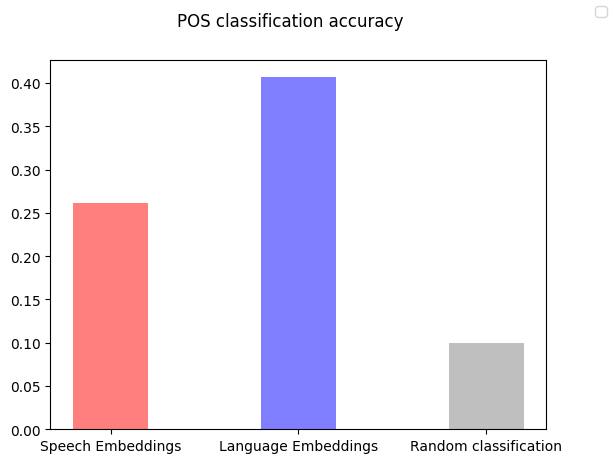

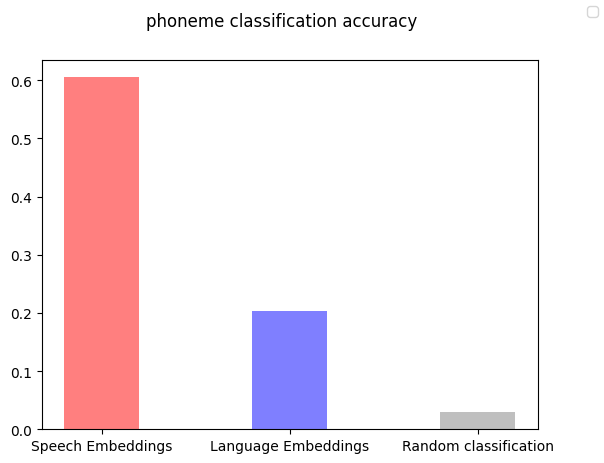

In [17]:
import matplotlib.pyplot as plt

for category_name in ["POS", "phoneme"]:
  fig, ax = plt.subplots()
  random_acc = 1.0/len(set(unique_words_df[category_name]))
  accs = embd_acc_dict[category_name]
  accs.append(random_acc)

  tick_label_list = ["Speech Embeddings", "Language Embeddings", "Random classification"]
  ax.bar([1, 1.5, 2], width=0.2, height=accs, tick_label=tick_label_list,
         color=['red', 'blue','grey'], align='center', alpha=0.5)

  fig.legend()
  fig.suptitle(f"{category_name} classification accuracy")
  fig.savefig(f"{category_name}_linear_class.png")